# virus_on_network

Search for virus_on_network on google to find some explanation about this model

In [ ]:
# This model is compatible with mesa version 1.1.1

*In this assignment, you'll engage with this fun model to simulate virus propagation across various network topologies. You'll investigate how different network structures affect the transition rates among agent states: susceptible, infected, and resistant. As the simulation progresses, you'll observe emergent behaviors resulting from agent interactions and network configurations. You'll also introduce external scenarios and policy interventions into the model. This will allow you to examine how events like virus mutations or the discovery of a cure can alter the dynamics of the system. Additionally, you'll explore strategies that individual agents can adopt to mitigate infection risks.*

# Learning Objectives

* Network Topology on Agent States (Related to Exercises 1 & 2)
    * Network Visualization: You should be able to generate visual representations of networks, with emphasis on how different topologies affect the spread of states among agents.
    * Data Interpretation: You should be able to analyze and interpret how different topologies influence individual agent states, as well as the overall network state.
* Implementation of Scenarios and Events (Related to Exercise 3 & 4)
    * Scenario Design: You should be able to create and implement scenarios that introduce external changes or events into the simulation
    * Scenario Analysis: You should be able to evaluate the impact of these scenarios on the network and agent states, particularly in the context of different network topologies.
* Formulation and Assessment of Policies (Related to Exercises 4 & 5)
    * Policy Creation: You should be able to devise policies that can be implemented as interventions in the network
    * Policy Evaluation: You should be able to assess the effectiveness of these policies, both in isolation and in conjunction with external scenarios, across various network topologies.

# 1. Base model

In [22]:
import math  # Importing the math library for mathematical operations
from enum import Enum  # Importing Enum for enumerations
import networkx as nx  # Importing networkx for network operations
import matplotlib.pyplot as plt  # Importing matplotlib for plotting

# Importing necessary modules from the Mesa library for agent-based modeling
from mesa import Agent, Model  
from mesa.time import RandomActivation  
from mesa.datacollection import DataCollector  
from mesa.space import NetworkGrid  

# Defining an enumeration class to represent the state of agents in the model
#w e are making our Enumeration class, to hold constants : https://docs.python.org/3/library/enum.html
class State(Enum):  
    SUSCEPTIBLE = 0  # Susceptible state
    INFECTED = 1  # Infected state
    RESISTANT = 2  # Resistant state

# Defining a list of network topologies to be used in the model
network_topologies = ['Newman-Strogatz','Barabasi-Albert','Complete']  

# Function to count the number of agents in a given state
def number_state(model, state):  
    return sum([1 for a in model.grid.get_all_cell_contents() if a.state is state])

# Function to count the number of infected agents
def number_infected(model):  
    return number_state(model, State.INFECTED)

# Function to count the number of susceptible agents
def number_susceptible(model):  
    return number_state(model, State.SUSCEPTIBLE)

# Function to count the number of resistant agents
def number_resistant(model):  
    return number_state(model, State.RESISTANT)

# Main model class
class VirusOnNetwork(Model):  
    """A virus model with some number of agents"""

    # Initialization method with default parameters
    def __init__(
        self,
        num_nodes=10,  # Number of nodes/agents
        avg_node_degree=3,  # Average degree of nodes in the network
        initial_outbreak_size=1,  # Initial number of infected nodes
        virus_spread_chance=0.4,  # Probability of spreading the virus
        virus_check_frequency=0.4,  # Frequency of checking infection
        recovery_chance=0.3,  # Probability of recovering from infection
        gain_resistance_chance=0.5,  # Probability of gaining resistance
        topology = 'Barabasi-Albert',  # Network topology
    ):

        self.num_nodes = num_nodes  # Initialize number of nodes
        prob = avg_node_degree / self.num_nodes  # Calculate the probability for network topology that we will use later

        # Initialize the network graph based on the chosen topology
        if topology == 'Newman-Strogatz':  
            self.G = nx.newman_watts_strogatz_graph(n=self.num_nodes, k= 3, p = prob)
        if topology == 'Barabasi-Albert':  
            self.G = nx.barabasi_albert_graph(n=self.num_nodes, m=1)
        if topology == 'Complete':  
            self.G = nx.complete_graph(n=self.num_nodes)

        # Initialize the grid and scheduler
        self.grid = NetworkGrid(self.G)  
        self.schedule = RandomActivation(self)  
        self.initial_outbreak_size = (
            initial_outbreak_size if initial_outbreak_size <= num_nodes else num_nodes
        )
        self.virus_spread_chance = virus_spread_chance
        self.virus_check_frequency = virus_check_frequency
        self.recovery_chance = recovery_chance
        self.gain_resistance_chance = gain_resistance_chance

        # Initialize DataCollector
        self.datacollector = DataCollector(  
            {
                "Infected": number_infected,
                "Susceptible": number_susceptible,
                "Resistant": number_resistant,
            }
        )

        # Create agents and add them to the schedule and grid
        for i, node in enumerate(self.G):  
            a = VirusAgent(
                i,
                self,
                State.SUSCEPTIBLE,
                self.virus_spread_chance,
                self.virus_check_frequency,
                self.recovery_chance,
                self.gain_resistance_chance,
            )
            self.schedule.add(a)  
            self.grid.place_agent(a, node)  

        # Infect some agents initially
        infected_nodes = self.random.sample(list(self.G.nodes()), self.initial_outbreak_size)  
        for a in self.grid.get_cell_list_contents(infected_nodes):  
            a.state = State.INFECTED

        self.running = True  # Set the running state to True
        self.datacollector.collect(self)  # Collect initial data

    # Calculate the ratio of resistant to susceptible agents
    def resistant_susceptible_ratio(self):  
        try:
            return number_state(self, State.RESISTANT) / number_state(
                self, State.SUSCEPTIBLE
            )
        except ZeroDivisionError:  # Handle division by zero
            return math.inf

    # Define the step method that goes through one time step
    def step(self):  
        self.schedule.step()  # Activate the agents
        self.datacollector.collect(self)  # Collect data after the step
    
    #Function to easily run the model 
    def run_model(self, n):
        # Loop through the model 'n' times
        for i in range(n):
         # Call the 'step' method to advance the model by one time step
            self.step()


# Agent class
class VirusAgent(Agent):  
    """An agent in the virus model."""

    # Initialization method for agents
    def __init__(
        self,
        unique_id,  # Unique identifier for the agent
        model,  # Model instance the agent belongs to
        initial_state,  # Initial state of the agent
        virus_spread_chance,  # Probability of spreading the virus
        virus_check_frequency,  # Frequency of checking infection
        recovery_chance,  # Probability of recovering from infection
        gain_resistance_chance,  # Probability of gaining resistance
    ):
        super().__init__(unique_id, model)  # Initialize the superclass
        self.state = initial_state  # Set the initial state
        self.virus_spread_chance = virus_spread_chance  # Set the virus spread chance
        self.virus_check_frequency = virus_check_frequency  # Set the virus check frequency
        self.recovery_chance = recovery_chance  # Set the recovery chance
        self.gain_resistance_chance = gain_resistance_chance  # Set the gain resistance chance

    # Method to try and infect neighbors
    def try_to_infect_neighbors(self):  
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)  # Get neighboring nodes
        susceptible_neighbors = [
            agent
            for agent in self.model.grid.get_cell_list_contents(neighbors_nodes)
            if agent.state is State.SUSCEPTIBLE
        ]  # Filter out susceptible neighbors
        for a in susceptible_neighbors:  # Loop over each susceptible neighbor
            if self.random.random() < self.virus_spread_chance:  # Chance to infect. randomly picks a number and checks whether it is smaller than the spread chance. 
                                                                    #If it is smaller --> there is infection.
                a.state = State.INFECTED  # Change state to infected

    # Method to try and gain resistance
    def try_gain_resistance(self):  
        if self.random.random() < self.gain_resistance_chance:  # Chance to gain resistance
            self.state = State.RESISTANT  # Change state to resistant

    # Method to try and remove infection
    def try_remove_infection(self):  
        # Try to remove
        if self.random.random() < self.recovery_chance:  # Chance to recover
            # Success
            self.state = State.SUSCEPTIBLE  # Change state to susceptible
            self.try_gain_resistance()  # Attempt to gain resistance
        else:
            # Failed
            self.state = State.INFECTED

    # Method to check the current situation and take action
    def try_check_situation(self):  
        if self.random.random() < self.virus_check_frequency:  # Chance to check situation
            if self.state is State.INFECTED:  # If infected
                self.try_remove_infection()  # Try to remove infection

    # Define the actions to be taken in each step
    def step(self):  
        if self.state is State.INFECTED:  # If infected
            self.try_to_infect_neighbors()  # Try to infect neighbors
        self.try_check_situation()  # Check the situation


# 2. Visualization

KeyError: <__main__.VirusAgent object at 0x14200ead0>

Error in callback <function _draw_all_if_interactive at 0x113247e20> (for post_execute):


KeyError: <__main__.VirusAgent object at 0x14200ead0>

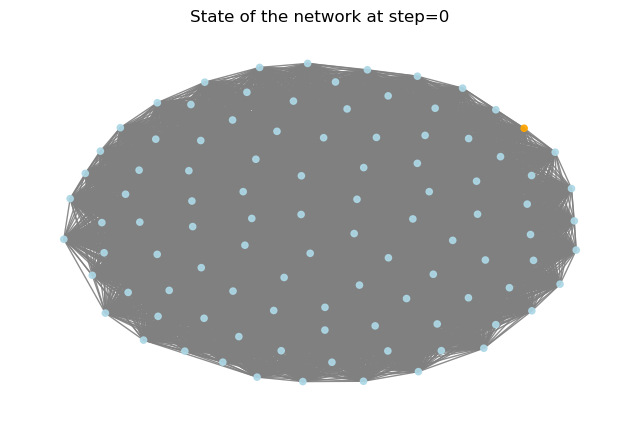

In [23]:
# Importing necessary libraries for animation and plotting
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, collections
from IPython.display import HTML

# Importing colormap utilities for node colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# Defining a custom colormap to represent different states
cmap = ListedColormap(["lightblue", "orange", "green",])

# as a reminder
# network_topologies = ['Newman-Strogatz','Barabasi-Albert','Complete']

# Creating a figure and axis for plotting
fig,ax=plt.subplots(1,1,figsize=(8,5))
# Initializing the VirusOnNetwork model with 100 nodes and a 'Complete' topology
model = VirusOnNetwork(100, topology=  'Complete')
# Getting the network graph from the model
graph = model.G
# Setting the positions of the nodes using the spring layout algorithm
pos = nx.spring_layout(graph, iterations=100)

# Function to update the animation frame
def update(frame):
    # Clearing the current plot
    plt.clf()
    # Re-creating the axis for plotting
    ax=fig.subplots()
    # Getting the states of all agents in the model
    states = [i.state for i in model.grid.get_all_cell_contents()]
    # Getting the colors corresponding to the states of all agents
    colors = [cmap(i.value) for i in states]
    # Drawing the network graph with updated colors
    nx.draw(graph, pos, node_size=20, edge_color='gray', node_color=colors, alpha=0.9,font_size=14,ax=ax)
    # Setting the title to show the current step
    ax.set_title("State of the network at step="+str(frame))
    # Advancing the model by one step
    model.step()

# Creating the animation object
anim = FuncAnimation(fig, update, interval = 100, frames=100)

# Displaying the animation as HTML5 video
HTML(anim.to_html5_video())  


In [ ]:
# Convenience function for creating the graph view
def draw_graph(model):
    # Defining a custom colormap to represent different states
    cmap = ListedColormap(["lightblue", "orange", "green",])
    # Getting the network graph from the model
    graph = model.G
    # Setting the positions of the nodes using the spring layout algorithm
    pos = nx.spring_layout(graph, iterations=100)
    
    # Creating a figure and axis for plotting
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    # Re-creating the axis for plotting (Note: This line may be redundant)
    ax = fig.subplots()
    # Getting the states of all agents in the model
    states = [i.state for i in model.grid.get_all_cell_contents()]
    # Getting the colors corresponding to the states of all agents
    colors = [cmap(i.value) for i in states]
    
    # Drawing the network graph with node colors based on agent states
    nx.draw(graph, pos, node_size=20, edge_color='gray', node_color=colors, alpha=0.9, font_size=14, ax=ax)
    # Setting the title to describe the graph topology and agent states
    ax.set_title("Topology of the graph and agent states")

# Call the draw_graph function to plot the graph
draw_graph(model)


In [ ]:
# Retrieve the agent-level data collected by the model's DataCollector
agent_data = model.datacollector.get_agent_vars_dataframe()

# Retrieve the model-level data collected by the model's DataCollector
model_data = model.datacollector.get_model_vars_dataframe()


In [ ]:
#print model data frame
model_data

# 3. Exercices

*These exercises are for this and next week, you do not need to finish them in 1 week.*


# Exercise 1: Network Topology and Virus Spread

In this exercise, you will investigate how different network topologies affect the spread of a virus across a population of agents. You will utilize both time-series plots and network visualizations to study these effects. This exercise is related to *Learning Objective 1: Network Topology on Agent States*



## 1a) Network Visualization
* Plot Infected/Susceptible/Resistant Over Time: Create a time-series plot that shows the number of Infected, Susceptible, and Resistant agents over time for each of the topologies available in the model.

* Graph View at the Last Step: Generate a network graph that visually represents the final states of agents in each topology. You can use the visualization example above.

*_Hint : Consider looping over the network_topologies list and use the subplot examples from previous weeks to generate multiple plots together.*

* EXTRA: create an animation that shows the graph advancing over time along with the state of the agents at each time step.




In [ ]:
# answer here


## 1b) Observation
* Explain Your Observations: Based on the visualizations you have generated, explain in a few words what you observe. How do different topologies affect the spread of the virus? Are there topologies where the virus spreads more quickly or more slowly?

In [ ]:
# answer here

# Exercise 2 Analyzing State Transitions of Individual Agents Across Different Network Topologies

Understanding the behavior of individual agents is crucial for a comprehensive analysis of the simulation. For each agent, we want to know how many times the agent has been in the states of SUSCEPTIBLE, INFECTED, and RESISTANT during the simulation. Additionally, we will explore how these state transitions are influenced by the topology of the network.  By focusing on these micro-level behaviors, you will gain insights into how network structure affects individual and overall system dynamics. This exercice is related to *Learning Objective 1: Network Topology on Agent States.*


## 2a) Implement Agent-Level Data Collection
* Modify the agent class to include a data collector at the agent level.

* The data collector should keep a count of how many times an agent transitions to each of the three states: SUSCEPTIBLE, INFECTED, and RESISTANT.
*_Hint: Consider adding state transition counters in the agent class.*



In [ ]:
# answer here


## 2b) Visualize Agent State Transitions Across Topologies
* For each network topology, generate a scatter plot with the following specifications:
    
    * Plot three points for each agent, representing the count of state changes to SUSCEPTIBLE, INFECTED, and RESISTANT. Use different colors for each state.
    
    * The y-axis should represent the count of state transitions.
    
    * The x-axis should represent the degree of the agent, which is the number of edges (connections) a node has. (The degree of an agent can be obtained using functions you've already employed in the Agent class.)
    
    * Generate this plot for the final timestep of the simulation.

.
* EXTRA: create an animation that updates these scatter plots at each timestep. This will allow you to observe how the state transitions evolve over time for each network topology.


In [ ]:
# answer here

# Exercise 3: Avoiding infection.

In this exercise, we explore the concept of adaptive behavior within the network model, specifically focusing on strategies that agents can employ to avoid infection. Agents will have the ability to sever connections based on their infection status and that of their neighbors. The goal is to understand how these individual decisions impact the overall network structure and the spread of infection, especially across different topologies. This exercice is relation to *Learning Objective 2: Implementation of Scenarios and Events.*


## 3a) Nodes Avoiding Re-infection

* When the agent has become infected, it has a chance that it will remove its connection with the agent that infected them. Modify the agent class to include a probability that an agent will remove its connection with another agent that has infected it.

* Reuse the analysis plots from earlier exercises to observe how this affects the network assuming different probabilities of removing the connection.


In [ ]:
# answer here


## 3b) Nodes Avoiding Infecting Others

* Make the nodes not want to infect others. When a node is infected, it will have a probability to disconnect from  other nodes that are susceptible. Extend the agent class to include a probability that an infected agent will disconnect from other agents that are susceptible.

* Again, reuse the analysis plots from earlier exercises to understand the implications of this behavior on the network for different probabilities of connection removal.


In [ ]:
# answer here


## 3c) Dual Strategy Implementation
What is the effect when agents use both strategies at the same time, for the different topologies?
* Investigate the impact when agents employ both strategies (from parts a and b) simultaneously, for different typologies

* What are the emergent effects on network structure and infection dynamics for different topologies?


In [ ]:
# answer here

# Exercise 4
(this exercise  will use the content from lectures on scenarios and policies. If you are here before those lectures, try to figure out a way how to do it!)

In this exercise, we  we will work with scenarios and policies within the epidemiological network model. While scenarios are external events that impact the model, policies are deliberate interventions aimed at producing a specific outcome. The focus here is to understand how these external factors and interventions affect the dynamics of infection spread in various network topologies. This exercise is related to *Learning Objective 2: Implementation of Scenarios and Events* and *Learning Objective 3: Formulation and Assessment of Policies*

***definitions***:

*A scenario is a sequence of 1 or more events that happen at specific points in time, and have a cause external to the model. I.e. they are things that are not caused by model or agent state, but "just happen" to the model.*

*A policy is a deliberate intervention (change to model or agent state or behavior) whose effect we want to understand. It can be happen either at the beginning of the model or at some point in time, triggered by the user or by some situation in the model.*


## 4a) Implementing Scenarios
* Create two scenarios :
    * "Virus Evolution  : Every 10 steps the chance to get infected by the virus increases by 20%
    
    * Cure Available : At step 20 a cure is found, and from then on, if infected, there is a 90 % chance that the node recovers. Cure does not change the infection rates.

* Run the model for 100 steps, and 100 agents. Explore the effect of these scenarios of different topologies. Explore the outcome using previous plots


In [ ]:
# answer here


## 4b) Policy Formulation

* Create a policy (that can be turned on or off) that allows you to vaccinate 10% of all nodes per timestep. Vaccinated nodes should only have a 10% chance of getting infected.

* Investigate the impact of this vaccination policy on the basic model across different network topologies.

In [ ]:
# answer here


## 4c) Policy Effects Under Different Scenarios
* Explore the effect of having or not having a vaccination policy under the base case, "Virus Evolution" and "Cure Available" scenarios


*Hint: You may need to run multiple simulations to capture the variability in outcomes.*


In [ ]:
# answer here

# Exercise 5 - Mortality, Quarantine, and Spatial Environment in Network Epidemiology
In this exercise, you'll extend the model to account for mortality, implement quarantine policies, and transition from a graph-based to a spatial environment. The aim is to understand how these added complexities interact with the existing model and influence the spread of the virus across different scenarios and topologies.
This exercise is related to *Learning Objective 3: Formulation and Assessment of Policies*



## 5a) Agent Mortality

* Modify the model so that agents can die after being sick for a configurable amount of time. When they die, they should be removed from the model.

* Investigate the model's behavior using the analysis plots from previous exercises.

*Hint: You'll need to add a counter for each agent to track how long they've been infected.*



In [ ]:
# answer here

## 5b) Quarantine Policy

* Implement a policy to isolate nodes for a configurable period when the number of deaths reaches a certain threshold. Nodes in isolation have a configurable chance of breaking quarantine.

* Investigate this policy's impact under the base case, "Virus Evolution," and "Cure Available" scenarios for varying thresholds and chances to break quarantine.

*Hint: You may want to create a new agent state for 'Quarantined'.*



In [ ]:
# answer here

## 5c) Transition to a 2D Hex Grid

* Replace the graph-based environment with a 2D hexagonal grid.

* Implement a normally distributed chance for agents to get infected based on their distance to a sick agent.

* Explore the scenarios and policies mentioned above in this new spatial context.

*Hint: You'll need to modify how agents interact based on their spatial relationships*


In [ ]:
# answer here

*If you've reached this point, it means you've either successfully finished all the complex models we've thrown your way throughout the course, or you've time-traveled straight to the grand finale. If it's the former, congratulations! now time for some revisions for the final exam! If it's the latter, well, you're either a genius or a daredevil—either way, may the odds be ever in your favor as you backtrack through the maze of computational challenges. On a lighter note, you're now officially ready to model a zombie apocalypse or solve world hunger—your pick!*

Omar and Igor